In [4]:
from deblur3d.data.tiff_sequence import TiffDataset
from deblur3d.transforms import GaussianIsoBlurCPUTransform  # your CPU blur
import pandas as pd

blur_tf = GaussianIsoBlurCPUTransform(
    fwhm_range=(6, 12), radius_mult=3,
    add_noise=True, poisson_gain_range=(400, 900),
    read_noise_std_range=(0.004, 0.012)
)

ds_train = TiffDataset(
    manifest_path="manifest.parquet",
    split=None,                      # or 'train' if you add a split column later
    patch_size=(64, 256, 256),
    blur_transform=blur_tf,
    balance="volume",
    samples_per_epoch= len(pd.read_parquet("manifest.parquet")) * 8  # optional
)

from torch.utils.data import DataLoader
loader = DataLoader(ds_train, batch_size=2, shuffle=False, num_workers=4, pin_memory=True)
sharp, blurred = next(iter(loader))
print(sharp.shape, blurred.shape)  # (B, D, H, W)


torch.Size([2, 64, 256, 256]) torch.Size([2, 64, 256, 256])


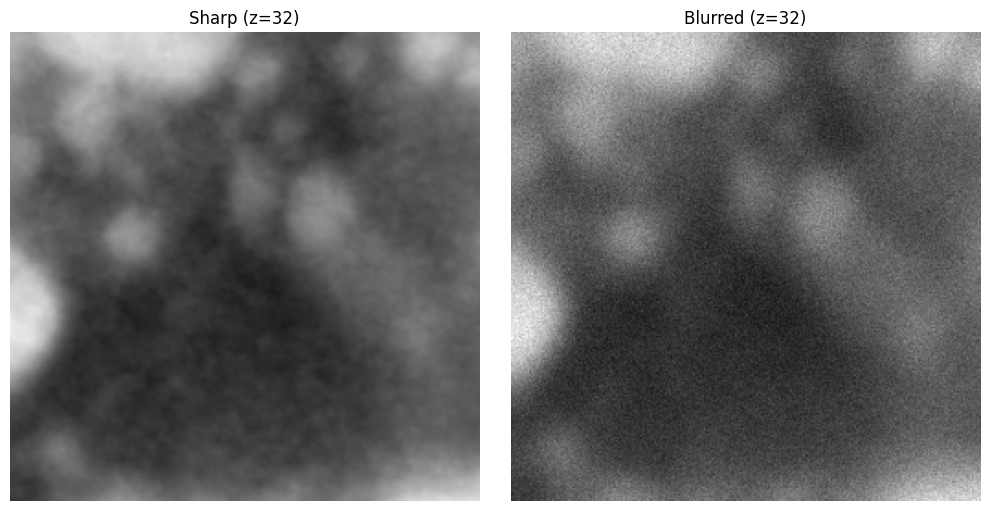

In [5]:
import matplotlib.pyplot as plt
import torch

# sharp, blurred from your DataLoader
# shapes: (B, D, H, W) torch.float32 in [0,1]

# pick first item in batch; move to CPU numpy
s = sharp[0].detach().cpu()
b = blurred[0].detach().cpu()

# central slice index along depth
z = s.shape[0] // 2

# consistent contrast limits across both
vmin = float(torch.minimum(s.min(), b.min()))
vmax = float(torch.maximum(s.max(), b.max()))

fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

axes[0].imshow(s[z].numpy(), cmap='gray', vmin=vmin, vmax=vmax)
axes[0].set_title(f"Sharp (z={z})")
axes[0].axis('off')

axes[1].imshow(b[z].numpy(), cmap='gray', vmin=vmin, vmax=vmax)
axes[1].set_title(f"Blurred (z={z})")
axes[1].axis('off')

plt.show()


In [7]:
import os, pandas as pd
from pathlib import Path

man_path = "manifest.parquet"  # or .csv
m = pd.read_parquet(man_path) if man_path.endswith(".parquet") else pd.read_csv(man_path)

print("Rows in manifest:", len(m))
display(m.head(10))

# Basic stats
cols = ["n_slices","H","W","dtype","lo","hi","root_dir"]
display(m[cols].describe(include="all"))

# Any paths that no longer exist?
missing = m[~m["root_dir"].map(os.path.exists)]
print("Missing on disk:", len(missing))
if len(missing):
    display(missing[["root_dir","n_slices","H","W","dtype"]].head(10))


Rows in manifest: 1301


,volume_id,project_path,root_dir,n_slices,H,W,dtype,lo,hi,spacing_y,spacing_x
0,K:/499-ServiceData/Services/2022/X22-0072_NaTP...,K:\499-ServiceData\Services\2022\X22-0072_NaTP...,K:\499-ServiceData\Services\2022\X22-0072_NaTP...,1824,1496,1880,uint16,3235.500,3778.5000,NaN,NaN
1,K:/499-ServiceData/Services/2022/X22-0072_NaTP...,K:\499-ServiceData\Services\2022\X22-0072_NaTP...,K:\499-ServiceData\Services\2022\X22-0072_NaTP...,32,1496,1880,uint16,3186.000,3736.5000,NaN,NaN
2,K:/499-ServiceData/Services/2022/X22-0072_NaTP...,K:\499-ServiceData\Services\2022\X22-0072_NaTP...,K:\499-ServiceData\Services\2022\X22-0072_NaTP...,1252,1436,1537,uint16,0.000,45494.0000,NaN,NaN
3,K:/499-ServiceData/Services/2022/X22-0070_Dubo...,K:\499-ServiceData\Services\2022\X22-0070_Dubois,K:\499-ServiceData\Services\2022\X22-0070_Dubo...,1440,1496,1880,uint16,2178.395,41993.0000,NaN,NaN
4,K:/499-ServiceData/Services/2022/X22-0070_Dubo...,K:\499-ServiceData\Services\2022\X22-0070_Dubois,K:\499-ServiceData\Services\2022\X22-0070_Dubo...,647,282,643,uint16,0.000,43162.6875,NaN,NaN
5,K:/499-ServiceData/Services/2022/X22-0070_Dubo...,K:\499-ServiceData\Services\2022\X22-0070_Dubois,K:\499-ServiceData\Services\2022\X22-0070_Dubo...,32,1496,1880,uint16,2178.500,42007.0000,NaN,NaN
6,K:/499-ServiceData/Services/2022/X22-0070_Dubo...,K:\499-ServiceData\Services\2022\X22-0070_Dubois,K:\499-ServiceData\Services\2022\X22-0070_Dubo...,1636,822,1640,uint16,0.000,45320.6050,NaN,NaN
7,K:/499-ServiceData/Services/2022/X22-0070_Dubo...,K:\499-ServiceData\Services\2022\X22-0070_Dubois,K:\499-ServiceData\Services\2022\X22-0070_Dubo...,32,1496,1880,uint16,1935.000,44267.0000,NaN,NaN
8,K:/499-ServiceData/Services/2022/X22-0070_Dubo...,K:\499-ServiceData\Services\2022\X22-0070_Dubois,K:\499-ServiceData\Services\2022\X22-0070_Dubo...,1824,1496,1880,uint16,1973.500,44268.5000,NaN,NaN
9,K:/499-ServiceData/Services/2022/X22-0079_nzps...,K:\499-ServiceData\Services\2022\X22-0079_nzps...,K:\499-ServiceData\Services\2022\X22-0079_nzps...,1440,1496,1880,uint16,6046.000,9633.0000,NaN,NaN


,n_slices,H,W,dtype,lo,hi,root_dir
count,1301.000000,1301.000000,1301.000000,1301,1301.000000,1301.000000,1301
unique,NaN,NaN,NaN,2,NaN,NaN,1301
top,NaN,NaN,NaN,uint16,NaN,NaN,K:\499-ServiceData\Services\2022\X22-0072_NaTP...
freq,NaN,NaN,NaN,1240,NaN,NaN,1
mean,991.444274,1542.133743,1777.270561,NaN,5670.923267,29934.761347,NaN
std,1042.117970,706.203978,845.075794,NaN,6787.286634,18901.435022,NaN
min,32.000000,127.000000,158.000000,NaN,0.000000,117.000000,NaN
25%,142.000000,1275.000000,1439.000000,NaN,18.000000,11059.000000,NaN
50%,1000.000000,1496.000000,1665.000000,NaN,2923.500000,32953.000000,NaN
75%,1440.000000,1880.000000,1880.000000,NaN,9101.970000,44264.500000,NaN


Missing on disk: 0


In [9]:
from itertools import islice
log_path = Path(man_path).with_suffix(".index_log.jsonl")
if log_path.exists():
    print("Index log (first 20 lines):")
    with open(log_path, "r", encoding="utf-8") as f:
        for line in islice(f, 20):
            print(line.strip())


Index log (first 20 lines):
{"level": "warn", "scan_dir": "K:\\499-ServiceData\\Services\\2023\\X20-0066_Henning\\Pretests\\Highres_fromeppendorf\\SlicesY_Highres", "msg": "Slice K:\\499-ServiceData\\Services\\2023\\X20-0066_Henning\\Pretests\\Highres_fromeppendorf\\SlicesY_Highres\\SlicesY_Highres.tif not 2D (got (923, 1646, 1694))"}
{"level": "warn", "scan_dir": "K:\\499-ServiceData\\Services\\2024\\X24-0011_PtC\\PtC 2023.03.30\\xrf-xrd_ptc-e23139_2-pdf_2023-05-02_1324\\Microscopy_EDX_PtC E23139\\Matteo", "msg": "Slice K:\\499-ServiceData\\Services\\2024\\X24-0011_PtC\\PtC 2023.03.30\\xrf-xrd_ptc-e23139_2-pdf_2023-05-02_1324\\Microscopy_EDX_PtC E23139\\Matteo\\1835 25500 x Pt-C_E23139 HAADF STEM HAADF.tif not 2D (got (1024, 1024, 3))"}
{"level": "warn", "scan_dir": "K:\\499-ServiceData\\Services\\2024\\X24-0002_Sabya_Wenyu\\AdaptiveThreshold\\data\\4throundofscan\\FF40_PV6P\\SlicesY-FF40_PV6P", "msg": "Slice K:\\499-ServiceData\\Services\\2024\\X24-0002_Sabya_Wenyu\\AdaptiveThreshold

In [11]:
import pandas as pd

m = pd.read_parquet("manifest.parquet")   # or read_csv(...)
print("Rows:", len(m))
print("Unique root_dir:", m["root_dir"].nunique())  # should match rows

# What the dataset will actually use (skips missing dirs)
from deblur3d.data import TiffDataset
ds = TiffDataset("data/manifest.parquet", patch_size=(64,256,256))
print("Usable volumes in dataset:", len(ds.vols))


Rows: 1301
Unique root_dir: 1301


ImportError: cannot import name 'TiffDataset' from 'deblur3d.data' (C:\Users\taki\DeepDeBlur3D\src\deblur3d\data\__init__.py)

In [10]:
import pandas as pd

df = pd.read_parquet(r"C:\Users\taki\DeepDeBlur3D\manifest.parquet")
print(df[["project_path","root_dir","n_slices"]])
k=2; gc="project_path"
df2 = (df.sort_values([gc,"root_dir"])
         .groupby(gc, group_keys=False)
         .apply(lambda g: g.head(k))
         .reset_index(drop=True))
print("After head-K:\n", df2[["project_path","root_dir"]], len(df2))


ModuleNotFoundError: No module named 'pandas.io.formats.string'

In [7]:
import os
from pathlib import Path
import pandas as pd

# --- config ---
MANIFEST = "manifest.parquet"  # or .csv
METHOD   = "exact"                  # "exact" or "estimate"

# map common dtypes to bytes-per-pixel (extend if needed)
BPP = {
    "uint8":1, "int8":1,
    "uint16":2, "int16":2,
    "uint32":4, "int32":4,
    "float32":4, "float64":8,
    "double":8, "single":4,
}

def _load_manifest(path: str) -> pd.DataFrame:
    p = Path(path)
    if not p.exists():
        raise FileNotFoundError(p)
    if p.suffix.lower() == ".parquet":
        return pd.read_parquet(p)
    return pd.read_csv(p)

def _bytes_to_tb_tib(nbytes: int) -> tuple[float, float]:
    tb  = nbytes / 1_000_000_000_000  # decimal TB
    tib = nbytes / (1024**4)          # binary TiB
    return tb, tib

def _iter_slices(folder: Path):
    for f in folder.iterdir():
        if not f.is_file():
            continue
        n = f.name.lower()
        if not (n.endswith(".tif") or n.endswith(".tiff")):
            continue
        if n.startswith("proj_") or n.startswith("mask_"):
            continue
        yield f

def dataset_size_exact(df: pd.DataFrame) -> int:
    total = 0
    missing = 0
    for root in df["root_dir"]:
        d = Path(root)
        if not d.exists():
            missing += 1
            continue
        for f in _iter_slices(d):
            try:
                total += f.stat().st_size
            except OSError:
                pass
    if missing:
        print(f"Note: {missing} folders listed in manifest are missing on disk.")
    return total

def dataset_size_estimate(df: pd.DataFrame) -> int:
    # needs columns: n_slices, H, W, dtype
    if not {"n_slices","H","W","dtype"}.issubset(df.columns):
        raise ValueError("Manifest is missing one of: n_slices, H, W, dtype (required for estimate).")
    def bpp_of(dt: str) -> int:
        s = str(dt).lower()
        for k, v in BPP.items():
            if k in s:
                return v
        # fallback if unknown dtype
        return 2
    sizes = []
    for _, r in df.iterrows():
        n = int(r["n_slices"]); H = int(r["H"]); W = int(r["W"])
        bpp = bpp_of(r["dtype"])
        sizes.append(n * H * W * bpp)
    return int(sum(sizes))

# ---- run ----
df = _load_manifest(MANIFEST)

if METHOD == "exact":
    total_bytes = dataset_size_exact(df)
else:
    total_bytes = dataset_size_estimate(df)

tb, tib = _bytes_to_tb_tib(total_bytes)
print(f"Volumes in manifest: {len(df)}")
print(f"Total size ≈ {total_bytes:,} bytes  →  {tb:.3f} TB  ({tib:.3f} TiB)")


Volumes in manifest: 1301
Total size ≈ 9,413,393,497,346 bytes  →  9.413 TB  (8.561 TiB)
